# ETH-Only Crypto LSTM Classifier (3-Class)

This notebook builds a 3-class classifier using **ETH minute-level data**:
- **Data**: specific_assets_dataset_minute_granularity.csv (filtered to ETH only)
- **Features**: price_pct_change, volume_pct_change
- **Lookback**: 60 minutes of data
- **Prediction Window**: Next 60 minutes
- **Class 0**: Price +0.5% comes before -0.5% (BULLISH)
- **Class 1**: Price -0.5% comes before +0.5% (BEARISH)
- **Class 2**: Neither threshold hit within 60 min (NEUTRAL)
- **Asset**: ETH only (no asset embeddings needed)

In [87]:
# --- Setup & Config ---
import numpy as np
import pandas as pd
from typing import List, Dict
from pathlib import Path

import json
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.saving import save_model
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.utils import to_categorical

print("TF version:", tf.__version__)

TF version: 2.18.0


In [88]:
# Configuration
LOOKBACK_L = 30  # 60 minutes lookback
HORIZON_MINUTES = 10  # Predict 60 minutes ahead
EPOCHS = 50
TARGET = "target_class"
FEATURES = ["price_pct_change", "volume_pct_change"]
MIN_PCT_CHANGE = 0.002  # 0.5% threshold
DATA_THRESHOLD = 0.7  # 70% completeness required
TARGET_ASSET = "ETH"  # Only predict ETH price movements

print(f"""
📊 Model Configuration - ETH-Only 3-Class Classifier
────────────────────────────
TARGET_ASSET : {TARGET_ASSET} (predicting ETH only)
LOOKBACK_L   : {LOOKBACK_L} minutes
HORIZON      : {HORIZON_MINUTES} minutes (1 hour)
FEATURES     : {FEATURES}
TARGET       : {TARGET}
EPOCHS       : {EPOCHS}
MIN_PCT_CHANGE: {MIN_PCT_CHANGE} ({MIN_PCT_CHANGE*100}%)
DATA_THRESHOLD: {DATA_THRESHOLD} ({DATA_THRESHOLD*100}%)
────────────────────────────
Classification (3-class):
  Class 0: Price moves UP ≥0.5% within next hour (BULLISH)
  Class 1: Price moves DOWN ≥0.5% within next hour (BEARISH)
  Class 2: Price stays within ±0.5% for next hour (NEUTRAL)
  
✅ All samples kept - NEUTRAL is a valid class
────────────────────────────
""")


📊 Model Configuration - ETH-Only 3-Class Classifier
────────────────────────────
TARGET_ASSET : ETH (predicting ETH only)
LOOKBACK_L   : 30 minutes
HORIZON      : 10 minutes (1 hour)
FEATURES     : ['price_pct_change', 'volume_pct_change']
TARGET       : target_class
EPOCHS       : 50
MIN_PCT_CHANGE: 0.002 (0.2%)
DATA_THRESHOLD: 0.7 (70.0%)
────────────────────────────
Classification (3-class):
  Class 0: Price moves UP ≥0.5% within next hour (BULLISH)
  Class 1: Price moves DOWN ≥0.5% within next hour (BEARISH)
  Class 2: Price stays within ±0.5% for next hour (NEUTRAL)
  
✅ All samples kept - NEUTRAL is a valid class
────────────────────────────



## Load Multi-Asset Data

In [89]:
# Load minute-level data
df_wide = pd.read_csv("../data/specific_assets_dataset_minute_granularity.csv", dtype={"time": "string"})

# Parse timestamp
df_wide["time"] = pd.to_datetime(df_wide["time"], format="ISO8601", utc=True)

# Rename *_close -> *_price for consistency
rename_map = {}
for col in df_wide.columns:
    if col.endswith("_close"):
        asset = col.rsplit("_", 1)[0]
        rename_map[col] = f"{asset}_price"

if rename_map:
    df_wide = df_wide.rename(columns=rename_map)
    print("Renamed columns:", rename_map)

# Filter out sparse assets
threshold = DATA_THRESHOLD
n_rows = len(df_wide)

asset_prefixes = {c.split("_")[0] for c in df_wide.columns if "_" in c and c != "time"}
drop_cols = []
dropped_assets = []

for a in sorted(asset_prefixes):
    p, v = f"{a}_price", f"{a}_volume"
    if p in df_wide.columns and v in df_wide.columns:
        frac_price = df_wide[p].notna().mean()
        frac_volume = df_wide[v].notna().mean()
        if (frac_price < threshold) or (frac_volume < threshold):
            drop_cols += [p, v]
            dropped_assets.append((a, frac_price, frac_volume))

if drop_cols:
    df_wide = df_wide.drop(columns=drop_cols)
    print("\n🗑️  Dropped sparse assets (name, price%, volume%):")
    for a, fp, fv in dropped_assets:
        print(f"  {a:6s}  price={fp:.2%}, volume={fv:.2%}")

remaining_assets = sorted({c.split("_")[0] for c in df_wide.columns if "_" in c and c != "time"})
print(f"\n✅ Remaining assets: {remaining_assets} (total: {len(remaining_assets)})")
print(f"   Date range: {df_wide['time'].min()} to {df_wide['time'].max()}")
print(f"   Total rows: {len(df_wide):,}")


🗑️  Dropped sparse assets (name, price%, volume%):
  BNB     price=25.94%, volume=25.94%
  OP      price=16.72%, volume=16.72%
  POL     price=56.19%, volume=56.19%
  STRK    price=57.34%, volume=57.34%

✅ Remaining assets: ['AAVE', 'ADA', 'ARB', 'AVAX', 'BTC', 'ETH', 'LINK', 'MKR', 'NEAR', 'SOL', 'UNI'] (total: 11)
   Date range: 2023-11-06 16:28:00+00:00 to 2025-11-10 16:24:00+00:00
   Total rows: 1,046,523


## Find Overlapping Time Window

In [90]:
def find_majority_window(df_wide, min_frac=0.7):
    """
    Find the longest contiguous time window where ALL remaining assets
    have at least min_frac completeness within that window.
    """
    df = df_wide.copy()
    df['time'] = pd.to_datetime(df['time'], utc=True)
    
    assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})
    price_cols = [f"{a}_price" for a in assets if f"{a}_price" in df.columns]
    
    asset_ranges = {}
    for col in price_cols:
        valid_mask = df[col].notna()
        if valid_mask.any():
            first_idx = df[valid_mask].index[0]
            last_idx = df[valid_mask].index[-1]
            asset_ranges[col] = (first_idx, last_idx)
    
    if not asset_ranges:
        raise RuntimeError("No assets have any data")
    
    start_idx = max(start for start, end in asset_ranges.values())
    end_idx = min(end for start, end in asset_ranges.values())
    
    if start_idx > end_idx:
        raise RuntimeError("No overlapping time range for all assets")
    
    window = df.loc[start_idx:end_idx].copy()
    window_length = len(window)
    
    all_meet_threshold = True
    for col in price_cols:
        completeness = window[col].notna().mean()
        if completeness < min_frac:
            all_meet_threshold = False
            print(f"  {col} only has {completeness:.1%} completeness in overlapping window")
    
    if not all_meet_threshold:
        print(f"\n⚠️  Warning: Some assets don't meet {min_frac:.0%} threshold in the overlapping window.")
        print(f"  Consider lowering min_frac or using a different time range strategy.")
    
    start_time = df.loc[start_idx, 'time']
    end_time = df.loc[end_idx, 'time']
    
    runs = pd.DataFrame([{
        'start': start_time,
        'end': end_time,
        'length': window_length
    }], index=[0])
    
    return start_time, end_time, runs

In [91]:
# Find overlapping window where ALL assets have at least 70% completeness
start, end, runs = find_majority_window(df_wide, min_frac=0.7)
print("Best window:", start, "→", end, f"(length {runs['length'].max()} rows)")
print(f"Window duration: {(end - start).days / 365.25:.1f} years")

Best window: 2023-11-06 16:49:00+00:00 → 2025-11-10 16:24:00+00:00 (length 1046502 rows)
Window duration: 2.0 years


In [92]:
df_cut = df_wide[(df_wide["time"] >= start) & (df_wide["time"] <= end)].copy()

print("Original shape:", df_wide.shape)
print("Trimmed shape:", df_cut.shape)
print("Window:", start, "→", end)

Original shape: (1046523, 23)
Trimmed shape: (1046502, 23)
Window: 2023-11-06 16:49:00+00:00 → 2025-11-10 16:24:00+00:00


## Reshape wide → long & minute reindex

In [93]:
df = df_cut.copy()
df['time'] = pd.to_datetime(df['time'], utc=True)

assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})

# Keep only price/volume pairs that actually exist
keep_cols = ["time"] + [f"{a}_price" for a in assets if f"{a}_price" in df.columns] + [f"{a}_volume" for a in assets if f"{a}_volume" in df.columns]
df = df[keep_cols]

# Build MultiIndex columns (asset, field)
mi_cols = [("__meta__","time")] + [(a,"price") for a in assets if f"{a}_price" in df.columns] + [(a,"volume") for a in assets if f"{a}_volume" in df.columns]
df.columns = pd.MultiIndex.from_tuples(mi_cols)

# To long panel
df = df.set_index(("__meta__","time"))
df.columns.names = ["asset","field"]
long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})
long = long[["time","asset","price","volume"]].sort_values(["asset","time"]).reset_index(drop=True)

# Minute reindex & light fill
def reindex_minute(g):
    g = g.set_index("time").asfreq("1min")
    # Guard against non-positive price
    g.loc[g["price"] <= 0, "price"] = np.nan
    g["price"] = g["price"].ffill()
    # Forward fill volume too (better than 0 for occasional gaps)
    g["volume"] = g["volume"].ffill()
    # Only fill remaining NaNs with 0 (start of series)
    g["volume"] = g["volume"].fillna(0.0)
    return g.reset_index()

long = long.groupby("asset", group_keys=False).apply(reindex_minute)
print("Long shape after reindex:", long.shape)
long.head()

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_4445/3094707569.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})


Long shape after reindex: (11642136, 4)


/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_4445/3094707569.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long = long.groupby("asset", group_keys=False).apply(reindex_minute)


field,time,asset,price,volume
0,2023-11-06 16:49:00+00:00,AAVE,96.13,61.611
1,2023-11-06 16:50:00+00:00,AAVE,95.97,37.419
2,2023-11-06 16:51:00+00:00,AAVE,96.06,4.149
3,2023-11-06 16:52:00+00:00,AAVE,96.16,15.678
4,2023-11-06 16:53:00+00:00,AAVE,96.27,41.939


## Feature Engineering & Classification Labels

In [94]:
# Clean feature engineering
long = long.sort_values(["asset","time"]).drop_duplicates(["asset","time"]).reset_index(drop=True)

# Check data quality after forward fill
print("\n📊 Data Quality Check (after forward fill):")
print(f"Total rows: {len(long):,}")
print(f"\nMissing values:")
print(f"  Price NaN: {long['price'].isna().sum():,} ({long['price'].isna().sum()/len(long)*100:.2f}%)")
print(f"  Volume == 0: {(long['volume'] == 0).sum():,} ({(long['volume'] == 0).sum()/len(long)*100:.2f}%)")
print(f"  Volume NaN: {long['volume'].isna().sum():,} ({long['volume'].isna().sum()/len(long)*100:.2f}%)")

# Features: percentage changes
long["price_pct_change"] = long.groupby("asset")["price"].pct_change(1)
long["volume_pct_change"] = long.groupby("asset")["volume"].pct_change(1)

# Forward fill inf values in volume_pct_change (from 0 → positive transitions)
def forward_fill_inf(group):
    """Forward fill inf values, then replace remaining with 0"""
    mask_inf = np.isinf(group["volume_pct_change"])
    if mask_inf.any():
        group.loc[mask_inf, "volume_pct_change"] = np.nan
        group["volume_pct_change"] = group["volume_pct_change"].ffill()
        group["volume_pct_change"] = group["volume_pct_change"].fillna(0.0)
    return group

long = long.groupby("asset", group_keys=False).apply(forward_fill_inf).reset_index(drop=True)

# Drop initial NaNs from pct_change
before = len(long)
long = long.dropna(subset=["price_pct_change", "volume_pct_change"]).reset_index(drop=True)
after = len(long)
print(f"Dropped {before-after:,} rows with NaNs from pct_change")

long.head()


📊 Data Quality Check (after forward fill):
Total rows: 11,522,913

Missing values:
  Price NaN: 0 (0.00%)
  Volume == 0: 177,981 (1.54%)
  Volume NaN: 0 (0.00%)


/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_4445/200494871.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long = long.groupby("asset", group_keys=False).apply(forward_fill_inf).reset_index(drop=True)


Dropped 11 rows with NaNs from pct_change


field,time,asset,price,volume,price_pct_change,volume_pct_change
0,2023-11-06 16:50:00+00:00,AAVE,95.97,37.419,-0.001664,-0.392657
1,2023-11-06 16:51:00+00:00,AAVE,96.06,4.149,0.000938,-0.889121
2,2023-11-06 16:52:00+00:00,AAVE,96.16,15.678,0.001041,2.778742
3,2023-11-06 16:53:00+00:00,AAVE,96.27,41.939,0.001144,1.675022
4,2023-11-06 16:54:00+00:00,AAVE,96.14,35.552,-0.001350,-0.152293


In [95]:
# Create classification labels
def classify_direction(group):
    """
    For each sample:
    1. Take price at LAST timestep of input window (i + LOOKBACK_L - 1)
    2. Look at next 60 minutes
    3. If +0.5% comes first: Class 0 (BULLISH)
    4. If -0.5% comes first: Class 1 (BEARISH)
    5. If neither: Class 2 (NEUTRAL)
    """
    prices = group["price"].values
    classes = np.full(len(prices), 2, dtype=int)  # Default: NEUTRAL
    
    bullish_count = 0
    bearish_count = 0
    neutral_count = 0
    
    # For each possible sequence
    for i in range(len(prices) - LOOKBACK_L - HORIZON_MINUTES + 1):
        # Price at the LAST timestep of the input window
        reference_price = prices[i + LOOKBACK_L - 1]
        
        # Future prices (next 60 minutes AFTER the input window)
        future_prices = prices[i + LOOKBACK_L : i + LOOKBACK_L + HORIZON_MINUTES]
        
        # Calculate percentage changes from reference price
        pct_changes = (future_prices - reference_price) / reference_price
        
        # Find when thresholds are hit (if at all)
        bullish_idx = np.where(pct_changes > MIN_PCT_CHANGE)[0]
        bearish_idx = np.where(pct_changes < -MIN_PCT_CHANGE)[0]
        
        # Determine class based on which threshold hit first
        if len(bullish_idx) > 0 and len(bearish_idx) > 0:
            # Both thresholds hit - which came first?
            if bullish_idx[0] < bearish_idx[0]:
                classes[i] = 0  # BULLISH
                bullish_count += 1
            else:
                classes[i] = 1  # BEARISH
                bearish_count += 1
        elif len(bullish_idx) > 0:
            classes[i] = 0  # Only BULLISH threshold hit
            bullish_count += 1
        elif len(bearish_idx) > 0:
            classes[i] = 1  # Only BEARISH threshold hit
            bearish_count += 1
        else:
            classes[i] = 2  # NEUTRAL
            neutral_count += 1
    
    print(f"  {group['asset'].iloc[0]:6s}: BULLISH={bullish_count:5d}, BEARISH={bearish_count:5d}, NEUTRAL={neutral_count:5d}")
    
    group["target_class"] = classes
    return group

# 🎯 FILTER TO ETH ONLY FIRST
print("🎯 Filtering to ETH only...")
before_eth = len(long)
long = long[long["asset"] == "ETH"].copy()
after_eth = len(long)
print(f"Kept {after_eth:,} ETH samples (removed {before_eth - after_eth:,} samples from other assets)")

print("\nComputing classification labels for ETH minute-level data...")
print(f"Looking ahead {HORIZON_MINUTES} minutes for each sample...")
print(f"Using threshold: ±{MIN_PCT_CHANGE*100}%")
print(f"Reference price: LAST value of input window (timestep {LOOKBACK_L})\n")

# Apply classification to ETH only
long = classify_direction(long)

# Drop rows without complete forward windows
before = len(long)
long = long.iloc[:-(LOOKBACK_L + HORIZON_MINUTES - 1)].copy()
after = len(long)
print(f"\nKept {after:,} rows with valid labels (dropped {before-after:,} rows without complete windows)")

🎯 Filtering to ETH only...
Kept 1,046,472 ETH samples (removed 10,428,788 samples from other assets)

Computing classification labels for ETH minute-level data...
Looking ahead 10 minutes for each sample...
Using threshold: ±0.2%
Reference price: LAST value of input window (timestep 30)

Kept 1,046,472 ETH samples (removed 10,428,788 samples from other assets)

Computing classification labels for ETH minute-level data...
Looking ahead 10 minutes for each sample...
Using threshold: ±0.2%
Reference price: LAST value of input window (timestep 30)

  ETH   : BULLISH=252899, BEARISH=254248, NEUTRAL=539286

Kept 1,046,433 rows with valid labels (dropped 39 rows without complete windows)
  ETH   : BULLISH=252899, BEARISH=254248, NEUTRAL=539286

Kept 1,046,433 rows with valid labels (dropped 39 rows without complete windows)


In [96]:
# Check class distribution
class_counts = long["target_class"].value_counts().sort_index()
print("\n📊 ETH Class Distribution:")
print(f"  Class 0 (BULLISH): {class_counts.get(0, 0):,} ({class_counts.get(0, 0)/len(long)*100:.1f}%)")
print(f"  Class 1 (BEARISH): {class_counts.get(1, 0):,} ({class_counts.get(1, 0)/len(long)*100:.1f}%)")
print(f"  Class 2 (NEUTRAL): {class_counts.get(2, 0):,} ({class_counts.get(2, 0)/len(long)*100:.1f}%)")


📊 ETH Class Distribution:
  Class 0 (BULLISH): 252,899 (24.2%)
  Class 1 (BEARISH): 254,248 (24.3%)
  Class 2 (NEUTRAL): 539,286 (51.5%)


## Train / Validation / Test Split

In [97]:
t1 = long["time"].quantile(0.70)
t2 = long["time"].quantile(0.85)
train = long[long["time"] < t1].copy()
val = long[(long["time"] >= t1) & (long["time"] < t2)].copy()
test = long[long["time"] >= t2].copy()
print("Split sizes:", len(train), len(val), len(test))

Split sizes: 732503 156965 156965


## Create Sequences with Asset Embeddings

In [98]:
# Create asset ID mapping
asset_to_id = {a: i for i, a in enumerate(sorted(train["asset"].unique()))}
n_assets = len(asset_to_id)
feat_dim = len(FEATURES)
print(f"ETH-only model: {n_assets} asset (ETH)")

def make_sequences(df, L):
    """Create sequences for single asset (ETH only)"""
    X_list, y_list = [], []
    df = df.sort_values("time")
    X = df[FEATURES].values
    y = df[TARGET].values
    for t in range(L, len(df)):
        X_list.append(X[t-L:t,:])
        y_list.append(y[t])
    return np.stack(X_list), np.array(y_list, dtype=np.int32)

X_tr, y_tr = make_sequences(train, LOOKBACK_L)
X_va, y_va = make_sequences(val, LOOKBACK_L)
X_te, y_te = make_sequences(test, LOOKBACK_L)
print(f"Sequence shapes: train={X_tr.shape}, val={X_va.shape}, test={X_te.shape}")
print(f"Label shapes: train={y_tr.shape}, val={y_va.shape}, test={y_te.shape}")

y_tr_onehot = to_categorical(y_tr, num_classes=3)
y_va_onehot = to_categorical(y_va, num_classes=3)
y_te_onehot = to_categorical(y_te, num_classes=3)
print(f"\nOne-hot encoded labels: train={y_tr_onehot.shape}, val={y_va_onehot.shape}, test={y_te_onehot.shape}")

ETH-only model: 1 asset (ETH)
Sequence shapes: train=(732473, 30, 2), val=(156935, 30, 2), test=(156935, 30, 2)
Label shapes: train=(732473,), val=(156935,), test=(156935,)

One-hot encoded labels: train=(732473, 3), val=(156935, 3), test=(156935, 3)
Sequence shapes: train=(732473, 30, 2), val=(156935, 30, 2), test=(156935, 30, 2)
Label shapes: train=(732473,), val=(156935,), test=(156935,)

One-hot encoded labels: train=(732473, 3), val=(156935, 3), test=(156935, 3)


In [99]:
# Check for inf/nan values before scaling
for name, X in [("train", X_tr), ("val", X_va), ("test", X_te)]:
    n_inf = np.isinf(X).sum()
    n_nan = np.isnan(X).sum()
    if n_inf > 0 or n_nan > 0:
        print(f"  {name}: {n_inf} inf, {n_nan} nan values")

# Replace inf with nan, then fill with 0
X_tr = np.nan_to_num(X_tr, nan=0.0, posinf=0.0, neginf=0.0)
X_va = np.nan_to_num(X_va, nan=0.0, posinf=0.0, neginf=0.0)
X_te = np.nan_to_num(X_te, nan=0.0, posinf=0.0, neginf=0.0)

# Clip extreme values
X_tr = np.clip(X_tr, -1.0, 1.0)
X_va = np.clip(X_va, -1.0, 1.0)
X_te = np.clip(X_te, -1.0, 1.0)

# Reshape for scaling
n_samples_tr, n_timesteps, n_features = X_tr.shape
X_tr_flat = X_tr.reshape(-1, n_features)
X_va_flat = X_va.reshape(-1, n_features)
X_te_flat = X_te.reshape(-1, n_features)

# Fit RobustScaler on training data
scaler = RobustScaler()
X_tr_scaled = scaler.fit_transform(X_tr_flat)
X_va_scaled = scaler.transform(X_va_flat)
X_te_scaled = scaler.transform(X_te_flat)

# Reshape back to sequences
X_tr = X_tr_scaled.reshape(X_tr.shape)
X_va = X_va_scaled.reshape(X_va.shape)
X_te = X_te_scaled.reshape(X_te.shape)

print(f"✅ Features scaled - mean: {X_tr.mean():.6f}, std: {X_tr.std():.6f}")

✅ Features scaled - mean: 0.045548, std: 0.910210


In [100]:
# 🔍 DIAGNOSTIC: Check class distribution in splits
print("📊 Class Distribution Analysis:")
for name, y in [("train", y_tr), ("val", y_va), ("test", y_te)]:
    counts = np.bincount(y, minlength=3)
    total = len(y)
    print(f"\n{name}:")
    print(f"  Class 0 (BULLISH): {counts[0]:,} ({counts[0]/total*100:.1f}%)")
    print(f"  Class 1 (BEARISH): {counts[1]:,} ({counts[1]/total*100:.1f}%)")
    print(f"  Class 2 (NEUTRAL): {counts[2]:,} ({counts[2]/total*100:.1f}%)")

📊 Class Distribution Analysis:

train:
  Class 0 (BULLISH): 171,723 (23.4%)
  Class 1 (BEARISH): 173,373 (23.7%)
  Class 2 (NEUTRAL): 387,377 (52.9%)

val:
  Class 0 (BULLISH): 42,968 (27.4%)
  Class 1 (BEARISH): 41,354 (26.4%)
  Class 2 (NEUTRAL): 72,613 (46.3%)

test:
  Class 0 (BULLISH): 38,204 (24.3%)
  Class 1 (BEARISH): 39,502 (25.2%)
  Class 2 (NEUTRAL): 79,229 (50.5%)


## Model: MiniLOB CNN-LSTM Classifier (ETH-only, no embeddings)

In [101]:
# Use MiniLOB architecture from norm_features.ipynb
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Dropout

def create_minilob(T, NF, lstm_units=32):
    """
    Lightweight DeepLOB variant for small datasets.
    """
    inp = Input(shape=(T, NF, 1))

    # --- Simplified CNN block ---
    x = Conv2D(16, (1, 2), strides=(1, 2), padding='same')(inp)
    x = LeakyReLU(0.01)(x)
    x = Conv2D(16, (3, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 1))(x)

    # Optional second small block
    x = Conv2D(32, (3, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 1))(x)

    # --- Flatten spatial dims ---
    # Result: (batch, timesteps', features')
    tsteps = x.shape[1]
    fdim = int(x.shape[2]) * int(x.shape[3])
    x = Reshape((tsteps, fdim))(x)

    x = Dropout(0.2)(x)

    # --- LSTM ---
    x = LSTM(lstm_units)(x)

    # --- Output ---
    out = Dense(3, activation='softmax')(x)

    model = Model(inp, out)
    return model

# Reshape for CNN input: (samples, timesteps, features, channels)
X_tr_cnn = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], X_tr.shape[2], 1)
X_va_cnn = X_va.reshape(X_va.shape[0], X_va.shape[1], X_va.shape[2], 1)
X_te_cnn = X_te.reshape(X_te.shape[0], X_te.shape[1], X_te.shape[2], 1)

print(f"CNN input shapes: train={X_tr_cnn.shape}, val={X_va_cnn.shape}, test={X_te_cnn.shape}")

# Create MiniLOB model
T = X_tr_cnn.shape[1]  # timesteps (60)
NF = X_tr_cnn.shape[2]  # number of features (2)
lstm_units = 32

classifier = create_minilob(T, NF, lstm_units)

CNN input shapes: train=(732473, 30, 2, 1), val=(156935, 30, 2, 1), test=(156935, 30, 2, 1)


## Build TensorFlow Datasets

In [102]:
# ETH-only model doesn't need asset embeddings - simpler dataset
def make_ds(X, y, batch=256, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(X), 100000), reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_tr_cnn, y_tr_onehot, batch=256, shuffle=False)
val_ds = make_ds(X_va_cnn, y_va_onehot, batch=512, shuffle=False)
test_ds = make_ds(X_te_cnn, y_te_onehot, batch=512, shuffle=False)

for sample in train_ds.take(1):
    print(f"X shape: {sample[0].shape} -> y shape: {sample[1].shape}")

X shape: (256, 30, 2, 1) -> y shape: (256, 3)


In [103]:
classifier.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 1, 16)      │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 30, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 1, 16)      │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 1, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 30, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 15, 1, 32)      │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,011 (43.01 KB)

 Trainable params: 10,915 (42.64 KB)

 Non-trainable params: 96 (384.00 B)

## Train

In [104]:
from tensorflow.keras.optimizers import Adam

classifier.compile(
    loss='categorical_crossentropy',  # For one-hot encoded labels
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [105]:
results_path = Path('results', 'classification_models')
if not results_path.exists():
    results_path.mkdir(parents=True)

classifier_path = (results_path / 'eth_classifier.keras').as_posix()

checkpointer = ModelCheckpoint(
    filepath=classifier_path,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [106]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [107]:
# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr),
    y=y_tr
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("📊 Class Weights for Imbalance:")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")


📊 Class Weights for Imbalance:
  Class 0: 1.4218
  Class 1: 1.4083
  Class 2: 0.6303


In [108]:
# Training with class weights to handle imbalance
training = classifier.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, checkpointer],
    class_weight=class_weights, 
    verbose=1
)

Epoch 1/50
2857/2862 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5108 - loss: 1.0372
Epoch 1: val_accuracy improved from -inf to 0.26752, saving model to results/classification_models/eth_classifier.keras

Epoch 1: val_accuracy improved from -inf to 0.26752, saving model to results/classification_models/eth_classifier.keras
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.5107 - loss: 1.0373 - val_accuracy: 0.2675 - val_loss: 1.2870
Epoch 2/50
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.5107 - loss: 1.0373 - val_accuracy: 0.2675 - val_loss: 1.2870
Epoch 2/50
2857/2862 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5456 - loss: 0.9913
Epoch 2: val_accuracy improved from 0.26752 to 0.26914, saving model to results/classification_models/eth_classifier.keras

Epoch 2: val_accuracy improved from 0.26752 to 0.26914, saving model to results/classification_models/eth_classifier.keras
2862/2862 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.5455 - loss: 0.9914 - val_a

KeyboardInterrupt: 

## Evaluate

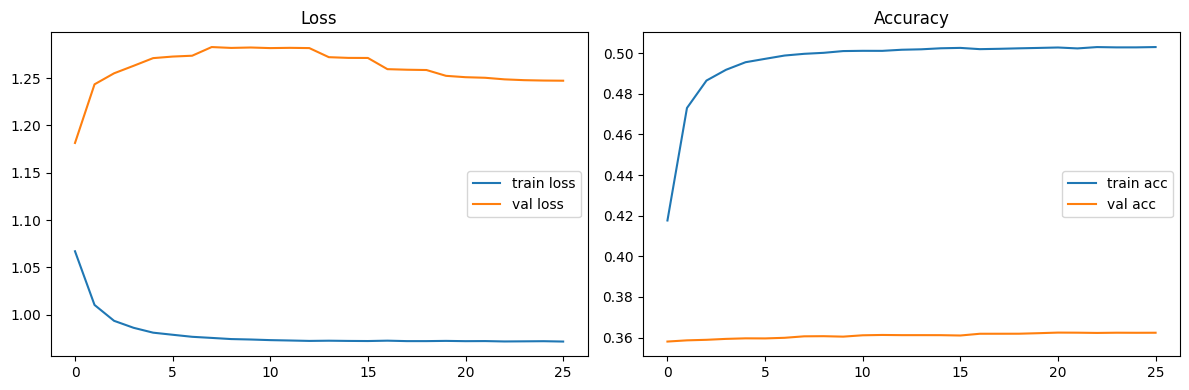

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], label='train loss')
plt.plot(training.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], label='train acc')
plt.plot(training.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
val_metrics = classifier.evaluate(val_ds, verbose=0)
test_metrics = classifier.evaluate(test_ds, verbose=0)
print(f"val_loss: {val_metrics[0]:.6f}, val_accuracy: {val_metrics[1]:.4f}")
print(f"test_loss: {test_metrics[0]:.6f}, test_accuracy: {test_metrics[1]:.4f}")

val_loss: 1.250909, val_accuracy: 0.3624
test_loss: 1.323611, test_accuracy: 0.3384


In [ ]:
# 💾 Save the trained model and asset mapping
print("💾 Saving trained classifier...")

classifier.save('results/classification_models/multiasset_classifier_final.keras')

# Save asset_to_id mapping
with open('results/classification_models/asset_to_id_multiasset.json', 'w') as f:
    json.dump(asset_to_id, f, indent=2)

print("✅ Classifier saved to:")
print("   - results/classification_models/multiasset_classifier_final.keras")
print("   - results/classification_models/asset_to_id_multiasset.json")

💾 Saving trained classifier...
✅ Classifier saved to:
   - results/classification_models/multiasset_classifier_final.keras
   - results/classification_models/asset_to_id_multiasset.json
✅ Classifier saved to:
   - results/classification_models/multiasset_classifier_final.keras
   - results/classification_models/asset_to_id_multiasset.json


## Classification Report

📊 Classification Report:
              precision    recall  f1-score   support

     BULLISH     0.3555    0.3833    0.3689     52902
     BEARISH     0.3287    0.6028    0.4254     54429
     NEUTRAL     0.0000    0.0000    0.0000     49562

    accuracy                         0.3384    156893
   macro avg     0.2280    0.3287    0.2647    156893
weighted avg     0.2339    0.3384    0.2719    156893



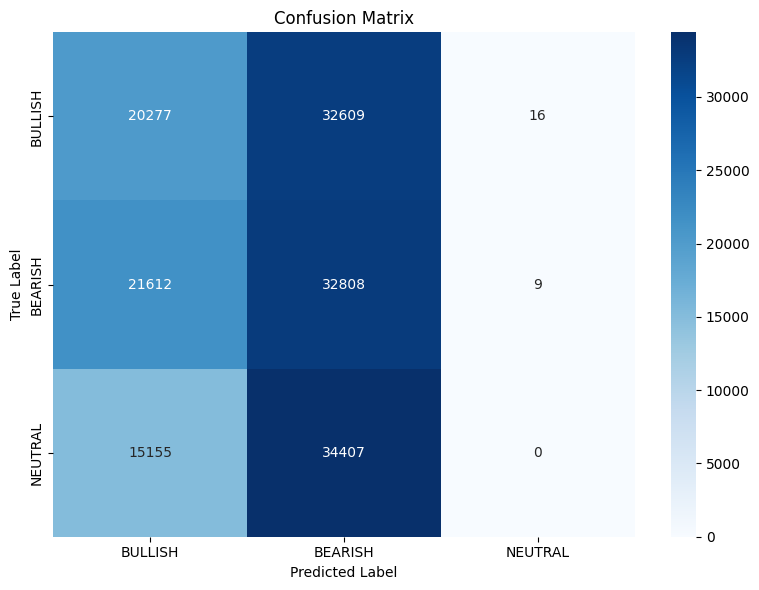


📈 Per-Class Accuracy:
  BULLISH: 38.33% (52902 samples)
  BEARISH: 60.28% (54429 samples)
  NEUTRAL: 0.00% (49562 samples)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred_probs = classifier.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("📊 Classification Report:")
print(classification_report(y_te, y_pred,
                          target_names=['BULLISH', 'BEARISH', 'NEUTRAL'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['BULLISH', 'BEARISH', 'NEUTRAL'],
            yticklabels=['BULLISH', 'BEARISH', 'NEUTRAL'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📈 Per-Class Accuracy:")
for i, label in enumerate(['BULLISH', 'BEARISH', 'NEUTRAL']):
    mask = y_te == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).mean()
        print(f"  {label}: {acc:.2%} ({mask.sum()} samples)")

In [ ]:
$%RT# Confidence analysis
print("\n🎯 Prediction Confidence Analysis:")
max_probs = y_pred_probs.max(axis=1)
print(f"Mean confidence: {max_probs.mean():.4f}")
print(f"Median confidence: {np.median(max_probs):.4f}")
print(f"Low confidence (<50%): {(max_probs < 0.5).sum()} ({(max_probs < 0.5).mean()*100:.1f}%)")
print(f"High confidence (>80%): {(max_probs > 0.8).sum()} ({(max_probs > 0.8).mean()*100:.1f}%)")

plt.figure(figsize=(10, 4))
plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='50% confidence')
plt.axvline(0.8, color='green', linestyle='--', label='80% confidence')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (4187407162.py, line 1)

In [ ]:
# Per-asset performance
print("\n📊 Per-Asset Performance:")
id_to_asset = {v: k for k, v in asset_to_id.items()}

for asset_id in range(n_assets):
    mask = A_te == asset_id
    if mask.sum() > 0:
        asset_name = id_to_asset[asset_id]
        asset_y_true = y_te[mask]
        asset_y_pred = y_pred[mask]
        accuracy = (asset_y_true == asset_y_pred).mean()
        print(f"  {asset_name:6s}: {accuracy:.2%} ({mask.sum():5d} samples)")


📊 Per-Asset Performance:



📊 Per-Asset Performance:


NameError: name 'A_te' is not defined